# Simulated Distributions

Visualize gene distributions for simulated data.

In [1]:
# system
import sys
sys.path.insert(0, '../BIVI/')
sys.path.insert(0, '../analysis_scripts/')

# math
import numpy as np
import torch

# data management
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 25})
plt.rcParams['image.cmap'] = 'Purples'
# colors
import matplotlib.colors as mcolors
sns.color_palette("Purples", as_cmap=True)


# sc
import anndata
import scanpy as sc

# my modules
from distributions import log_prob_NBuncorr, log_prob_poisson, log_prob_NBcorr
from nnNB_module import log_prob_nnNB
import differential_expression as de

device = 'cuda'

In [2]:
# load in data

# open a file, where you stored the pickled data
name = 'bursty_20ct_many'
data_dir = '../../data/simulated_data/'
results_file = open(f'../../results/{name}_results_dict.pickle', 'rb')
results_dict = pickle.load(results_file)
results_file.close()



data = 'simulated'

if data == 'simulated':
    simulated_params = np.load(f'../../data/simulated_data/{name}_params.npy')
else:
    simulated_params = None



# read in adata
adata = anndata.read_loom(data_dir+f'{name}.loom')
adata.var_names_make_unique()

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()
    
cell_types = results_dict.pop('Cell Type')
train_index = results_dict.pop('train_index')
test_index = results_dict.pop('test_index')


cluster_assignments = np.array([int(ct[2:]) for ct in cell_types])

# anndata objects for spliced and unspliced counts
adata_s = adata[:,adata.var['Spliced']==1].copy()    
adata_u = adata[:,adata.var['Spliced']==0].copy()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
cluster_labels = np.unique(np.array(adata.obs['Cell Type'].tolist()))

## Number of Cells per Cell Type

There are 619 cells in cell type CT0!
There are 467 cells in cell type CT1!
There are 708 cells in cell type CT10!
There are 1047 cells in cell type CT11!
There are 290 cells in cell type CT12!
There are 324 cells in cell type CT13!
There are 904 cells in cell type CT14!
There are 315 cells in cell type CT15!
There are 276 cells in cell type CT16!
There are 727 cells in cell type CT17!
There are 414 cells in cell type CT18!
There are 533 cells in cell type CT19!
There are 519 cells in cell type CT2!
There are 538 cells in cell type CT3!
There are 376 cells in cell type CT4!
There are 275 cells in cell type CT5!
There are 531 cells in cell type CT6!
There are 346 cells in cell type CT7!
There are 507 cells in cell type CT8!
There are 284 cells in cell type CT9!


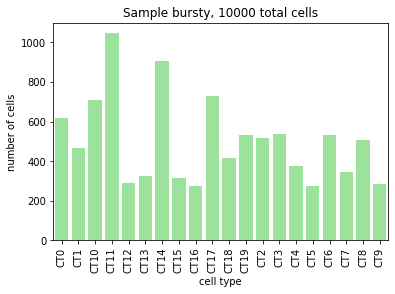

In [4]:
unique_ct = cluster_labels
num_cell_type = []
for ct in unique_ct:
    num_cells = adata[adata.obs['Cell Type']==ct,0].X.todense().shape[0]
    num_cell_type.append(num_cells)
    print(f'There are {num_cells} cells in cell type {ct}!')
    
sns.barplot(x=unique_ct,y = num_cell_type,color = 'lightgreen')
plt.xticks(rotation=90);
plt.xlabel('cell type')
sample = name.split('_')[0]
plt.title(f'Sample {sample}, {adata.shape[0]} total cells')
plt.ylabel('number of cells');

In [5]:
# marker genes for specifc cell type
unique_ct = cell_types.unique()
ct = 0
cell_type = unique_ct[ct]

# # print out marker genes 
marker_genes = adata[:,adata.var['Marker Annotation'] == ct].var_names.tolist()

# find the N most highly expressed spliced and unspliced genes in a certain cell type:
N = 10
total_spliced_counts = adata_s[adata_s.obs['Cell Type']==cell_type,:].layers['counts'].sum(axis=0)
total_unspliced_counts = adata_u[adata_u.obs['Cell Type']==cell_type,:].layers['counts'].sum(axis=0)

total_counts = np.ones((total_spliced_counts.shape[1],2))
total_counts[:,0] = total_unspliced_counts.flatten()
total_counts[:,1] = total_spliced_counts.flatten()
ind_s = np.argpartition(total_counts[:,0], -N)[-N:]
ind_u = np.argpartition(total_counts[:,1], -N)[-N:]

ind_both = [i for i in ind_s if i in ind_u]

In [6]:
# select gene
gene = 30

print(f'working with cell type: {cell_type}')
print(f'working with gene: {gene}')

# subset matrix to get spiced/unspliced counts
spliced_counts = adata_s[adata_s.obs['Cell Type']==cell_type,gene].layers['counts'].todense()
unspliced_counts = adata_u[adata_u.obs['Cell Type']==cell_type,gene].layers['counts'].todense()

# create matrix of observed counts
observed_counts = np.ones((spliced_counts.shape[0],2))
observed_counts[:,0] = unspliced_counts.flatten()
observed_counts[:,1] = spliced_counts.flatten()

nonzero_u = spliced_counts[unspliced_counts > 0].shape[1]
nonzero_s = spliced_counts[spliced_counts > 0].shape[1]
how_many_cells = len(unspliced_counts)
print(f'There are {how_many_cells} cells in {cell_type} cells')
print(f'There are {nonzero_u} cells in {cell_type} cells with nonzero UNSPLICED counts for this gene')
print(f'There are {nonzero_s} cells in {cell_type} cells with nonzero SPLICED counts for this gene')

working with cell type: CT0
working with gene: 30
There are 619 cells in CT0 cells
There are 332 cells in CT0 cells with nonzero UNSPLICED counts for this gene
There are 391 cells in CT0 cells with nonzero SPLICED counts for this gene


In [7]:
# now, get the log probabilities for a gene in a cell type for each method by AVERAGING probabilities for that gene

def reconstruct_ct_distribution(gene,cell_type,setups,max_vals=[10,10]):
    ''' Calculates the reconstructed probabilities for input gene for 
     all cells in cell type for each setup in setups. Averages probabilities over cells.
     Returns prob_dict with averaged probabilities for the specified gene in the specified cell type for 
     the input setups. 
     max_vals delimits the x,y values to calculate probabilities over.
    '''
    
    x,y = max_vals[0],max_vals[1]
    
    ct_number = int(cell_type[2:])

    x_grid, y_grid = torch.meshgrid(torch.range(0,x), torch.range(0,y))
    X = torch.concat((x_grid,y_grid),axis=1)

    prob_dict = {}

    for setup in setups:

        if 'scVI' in setup:
        # vanilla: 
            N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
            mus_u = results_dict[setup]['params']['mean'][cell_types == cell_type,gene]
            thetas_u = results_dict[setup]['params']['dispersions'][cell_types == cell_type,gene]
            mus_s =  results_dict[setup]['params']['mean'][cell_types == cell_type,gene+N]
            thetas_s = results_dict[setup]['params']['dispersions'][cell_types == cell_type,gene+N]

            mu1 = [torch.ones((x+1,y+1))*mus_u[i] for i in range(len(mus_u))]
            mu2 = [ torch.ones((x+1,y+1))*mus_s[i] for i in range(len(mus_s))]
            theta1 = [torch.ones((x+1,y+1))*thetas_u[i] for i in range(len(thetas_u))]
            theta2 = [torch.ones((x+1,y+1))*thetas_s[i] for i in range(len(thetas_s))]
            theta = [torch.concat((theta1[i],theta2[i]),axis=1) for i in range(len(theta1))]
    
        elif '-' in setup:
            N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
            mus_u = results_dict[setup]['params']['mean'][cell_types == cell_type,gene]
            mus_s =  results_dict[setup]['params']['mean'][cell_types == cell_type,gene+N]
            thetas = results_dict[setup]['params']['dispersions'][cell_types == cell_type,gene]
        
            mu1 = [torch.ones((x+1,y+1))*mus_u[i] for i in range(len(mus_u))]
            mu2 = [ torch.ones((x+1,y+1))*mus_s[i] for i in range(len(mus_u))]
            theta = [torch.ones((x+1,y+1))*thetas[i] for i in range(len(thetas))]

        if "scVI" in setup:
            prob = np.array([torch.exp(log_prob_NBuncorr(X, mu1[i], mu2[i], theta[i], eps = 1e-8, THETA_IS = 'NAS_SHAPE')).numpy()
                    for i in range(len(mu1))])

            prob_dict[setup] = np.sum(prob,axis=0)
        
        elif "Constitutive" in setup:
            prob = np.array([torch.exp(log_prob_poisson(X, mu1[i], mu2[i], theta[i], eps = 1e-8, THETA_IS = 'NAS_SHAPE')).numpy()
                    for i in range(len(mu1))])
            prob_dict[setup] = np.sum(prob,axis=0)
        
        elif "Bursty" in setup:
            prob = np.array([torch.exp(log_prob_nnNB(X.to(torch.device(device)), 
                                   mu1[i].to(torch.device(device)), 
                                   mu2[i].to(torch.device(device)), 
                                   theta[i].to(torch.device(device)), 
                                   eps = 1e-8, THETA_IS = 'NAS_SHAPE')).detach().cpu().numpy()
                                    for i in range(len(mu1))])
            prob_dict[setup] = np.sum(prob,axis=0)
    
        elif "Extrinsic" in setup:
            prob = np.array([torch.exp(log_prob_NBcorr(X, mu1[i], mu2[i], theta[i], eps = 1e-8, THETA_IS = 'NAS_SHAPE')).numpy()
                    for i in range(len(mu1))])
            prob_dict[setup] = np.sum(prob,axis=0)
        
        
        if 'TRUE' in setup:
            b, beta, gamma  = 10**simulated_params[ct_number,gene,:]
            av_mu_u,av_mu_s = b/beta, b/gamma
            av_theta = 1/beta
            mu1,mu2 = torch.ones((x+1,y+1))*av_mu_u, torch.ones((x+1,y+1))*av_mu_s
            theta = [torch.ones((x+1,y+1))*av_theta for i in range(len(mu1))]
            prob = np.array([torch.exp(log_prob_nnNB(X.to(torch.device(device)), 
                                   mu1[i].to(torch.device(device)), 
                                   mu2[i].to(torch.device(device)), 
                                   theta[i].to(torch.device(device)), 
                                   eps = 1e-8, THETA_IS = 'NAS_SHAPE')).detach().cpu().numpy()
                                    for i in range(len(mu1))])
        
            prob_dict[setup] = np.sum(prob,axis=0)
            
    return(prob_dict)




In [8]:
prob_dict =  reconstruct_ct_distribution(gene = 30, cell_type = 'CT0', 
                                         setups = ['Bursty-10-NAS_SHAPE','scVI-10-NAS_SHAPE','TRUE'],
                                         max_vals=[20,40])

<ipython-input-7-c4eef6e54308>:15: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x_grid, y_grid = torch.meshgrid(torch.range(0,x), torch.range(0,y))
/home/tara/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


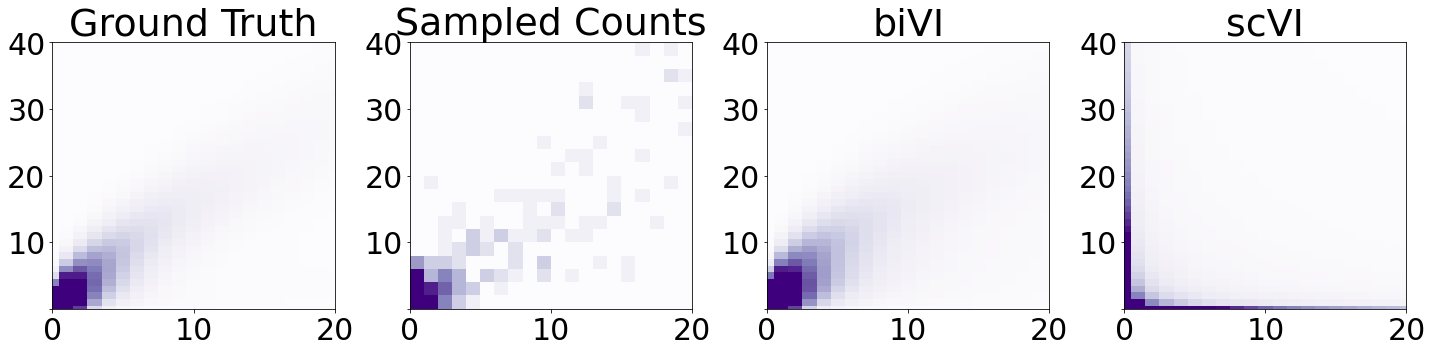

In [25]:
# Plot the distributions
xmin = 0
xmax = 20
ymin = 0
ymax = 40

fs = 38

setups_to_compare = ['Bursty-10-NAS_SHAPE','scVI-10-NAS_SHAPE']
setup_name_change = {'scVI-10-NAS_SHAPE':'scVI','Bursty-10-NAS_SHAPE': 'biVI','TRUE':'True'}

fig, axes = plt.subplots(1,4,figsize=(20,5))
#plt.figure(figsize=(4,4))


ax = axes[0]
ax.set_title('Ground Truth',fontsize=fs)

ax = axes[0]

ax.imshow(prob_dict['TRUE'].T/np.sum(prob_dict['TRUE']),vmin=0.00,vmax = 0.008)
#     forceAspect(ax)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_aspect('auto')
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

ax = axes[1]
# ax.set_title(f' {gene} in {cell_type}',fontsize=fs)
ax.set_title('Sampled Counts',fontsize=fs)
ax.hist2d(observed_counts[:,0],observed_counts[:,1],bins=(20,20),range = [[xmin,xmax],[ymin,ymax]],
         vmin=0.0,vmax = 10)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)


index = [2,3]
for i,setup in enumerate(setups_to_compare):
    i = index[i]
    ax = axes[i]
    setup_name = setup_name_change[setup]
    ax.set_title(f'{setup_name}',fontsize=fs)
    ax.imshow(prob_dict[setup].T/np.sum(prob_dict[setup]),vmin=0.00,vmax = 0.008)
#     forceAspect(ax)
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_aspect('auto')
    ax.yaxis.get_major_ticks()[0].label1.set_visible(False)


    

plt.tight_layout()

plt.savefig(f'../../results/{name}_figs/distribution_gene{gene}_ct{cell_type}.png',bbox_inches = 'tight')

-----

# Distribution of Gene Parameters

In [10]:
def get_bursty_params(mu1,mu2,theta):
    ''' Returns b, beta, gamma of bursty distribution given mu1, mu2 and theta.
    Returns whatever size was input. 
    '''
    
    b = mu1/theta
    beta = 1/theta
    gamma = mu1/(mu2*theta)
    
    
    return(b,beta,gamma)


def get_BVNB_params(mu1,mu2,theta):
    ''' Returns splicing rate beta, degradation rate gamma, and alpha (mean of transcription rate distribution) 
    given BVNB extrinsic noise model.
    '''
    alpha = theta
    beta = theta/mu1
    gamma = theta/mu2
    
    
    return(alpha,beta,gamma)

def get_constitutive_params(mu1,mu2):
    ''' Returns rate of splicing rate beta and rate of degradation gamma given constitutive model.
    '''
    beta = 1/mu1
    gamma = 1/mu2
    
    return(beta,gamma)
    

Look at distributions across cell type.


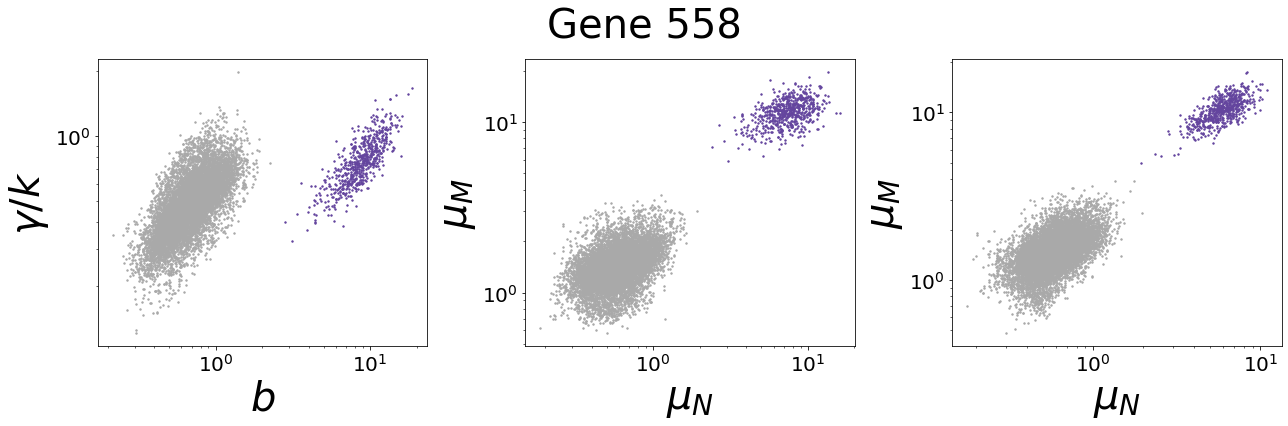

In [24]:
gene = 558
gene_name = str(gene)

fs = 40
fs_title = 40
model = 'bursty'
setup = 'Bursty-10-NAS_SHAPE'

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 

ct = 0
cell_type = unique_ct[ct]


            
fig, ax = plt.subplots(1,3, figsize = (18,6))
for i,cell_type in enumerate(unique_ct):
    N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
    mu1 = results_dict[setup]['params']['mean'][cell_types==cell_type,gene]
    mu2 =  results_dict[setup]['params']['mean'][cell_types==cell_type,gene+N]
    theta = results_dict[setup]['params']['dispersions'][cell_types==cell_type,gene]
    
    mu1_scVI = results_dict['scVI-10-NAS_SHAPE']['params']['mean'][cell_types==cell_type,gene]
    mu2_scVI =  results_dict['scVI-10-NAS_SHAPE']['params']['mean'][cell_types==cell_type,gene+N]
    
    
#     b_true = 10**simulated_params[ct,gene,0]
#     gamma_true = 10**simulated_params[ct,gene,2]
    if model == 'bursty':
        b,beta,gamma = get_bursty_params(mu1,mu2,theta)
    elif model == 'constitutive':
        beta,gamma = get_constitutive_params(mu1,mu2)
    elif model == 'BVNB':
        alpha,beta,gamma = get_BVNB_params(mu1,mu2,theta)
    
    
    if i == ct:
            color = plt.get_cmap('Purples')(200)
            z_order = 1
    else:
            color = 'darkgray'
            z_order = -1

            
    ax[0].scatter(b,gamma,s=2,label=f'{cell_type}',color=color)
#     if i == ct:
#         ax[0].scatter(b_true,gamma_true,s=400,marker='*',color='k')
    ax[0].set_ylabel('$\gamma/k$',fontsize = fs)
    ax[0].set_xlabel('$b$', fontsize = fs)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    #ax[0].grid(visible= True)
    ax[0].tick_params(labelsize = 20)
    
    ax[1].scatter(mu1,mu2,s=2,label=f'{cell_type}',color=color)
#     if i == ct:
#      plt.scatter(b_true,gamma_true,s=400,marker='*',color='k')
    ax[1].set_xlabel('$\mu_N$', fontsize = fs)
    ax[1].set_ylabel('$\mu_M$',fontsize = fs)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    #ax[1].grid(visible= True)
    ax[1].tick_params(labelsize = 20)
    
    ax[2].scatter(mu1_scVI,mu2_scVI,s=2,label=f'{cell_type}',color=color)
#     if i == ct:
#      plt.scatter(b_true,gamma_true,s=400,marker='*',color='k')
    ax[2].set_xlabel('$\mu_N$', fontsize = fs)
    ax[2].set_ylabel('$\mu_M$',fontsize = fs)
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    #ax[1].grid(visible= True)
    ax[2].tick_params(labelsize = 20)
    

#plt.legend(loc='center right',bbox_to_anchor=(1.5, 0.5),fontsize = 11.5,markerscale=4.)
plt.suptitle(f'Gene {gene_name}',fontsize = fs_title)
plt.tight_layout()

plt.savefig(f'../../results/{name}_figs/params_gene{gene_name}.png',bbox_inches = 'tight')


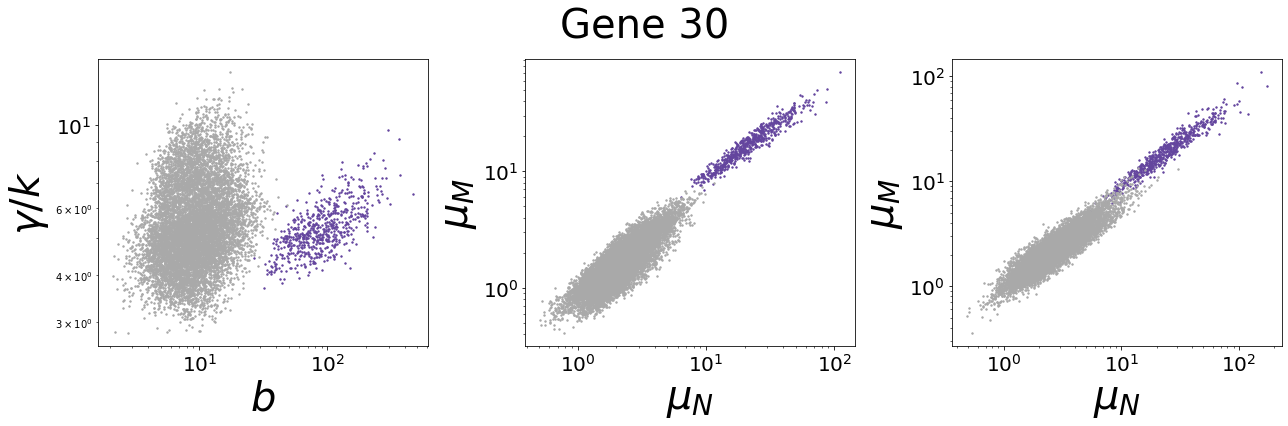

In [23]:
ct = 0
cell_type = unique_ct[ct]


gene = 30
gene_name = str(gene)
setup = 'Bursty-10-NAS_SHAPE'
model = 'bursty'

fig, ax = plt.subplots(1,3, figsize = (18,6))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
for i,cell_type in enumerate(unique_ct):
    N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
    mu1 = results_dict[setup]['params']['mean'][cell_types==cell_type,gene]
    mu2 =  results_dict[setup]['params']['mean'][cell_types==cell_type,gene+N]
    theta = results_dict[setup]['params']['dispersions'][cell_types==cell_type,gene]
    
    
    mu1_scVI = results_dict['scVI-10-NAS_SHAPE']['params']['mean'][cell_types==cell_type,gene]
    mu2_scVI =  results_dict['scVI-10-NAS_SHAPE']['params']['mean'][cell_types==cell_type,gene+N]
    
    

    if model == 'bursty':
        b,beta,gamma = get_bursty_params(mu1,mu2,theta)
    elif model == 'constitutive':
        beta,gamma = get_constitutive_params(mu1,mu2)
    elif model == 'BVNB':
        alpha,beta,gamma = get_BVNB_params(mu1,mu2,theta)
    
    
    if i == ct:
            color = plt.get_cmap('Purples')(200)
            #z_order = 1
    else:
            color = 'darkgray'
            #z_order = -1

            
    ax[0].scatter(b,gamma,s=2,label=f'{cell_type}',color=color)
#     if i == ct:
#         b_true = 10**simulated_params[i,gene,0]
#         gamma_true = 10**simulated_params[i,gene,2]
#         ax[0].scatter(b_true,gamma_true,s=400,marker='*',color='k')
    ax[0].set_ylabel('$\gamma/k$',fontsize = fs)
    ax[0].set_xlabel('$b$', fontsize = fs)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    #ax[0].grid(visible= True)
    ax[0].tick_params(labelsize = 20)
    
    ax[1].scatter(mu1,mu2,s=2,label=f'{cell_type}',color=color)
#     if i == ct:
#      plt.scatter(b_true,gamma_true,s=400,marker='*',color='k')
    ax[1].set_xlabel('$\mu_N$', fontsize = fs)
    ax[1].set_ylabel('$\mu_M$',fontsize = fs)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    #ax[1].grid(visible= True)
    ax[1].tick_params(labelsize = 20)

    
    ax[2].scatter(mu1_scVI,mu2_scVI,s=2,label=f'{cell_type}',color=color)
#     if i == ct:
#      plt.scatter(b_true,gamma_true,s=400,marker='*',color='k')
    ax[2].set_xlabel('$\mu_N$', fontsize = fs)
    ax[2].set_ylabel('$\mu_M$',fontsize = fs)
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    #ax[1].grid(visible= True)
    ax[2].tick_params(labelsize = 20)

#plt.legend(loc='center right',bbox_to_anchor=(1.5, 0.5),fontsize = 11.5,markerscale=4.)
plt.suptitle(f'Gene {gene_name}',fontsize = fs_title)
plt.tight_layout()

plt.savefig(f'../../results/{name}_figs/params_gene{gene_name}.png',bbox_inches = 'tight')


------

### Differential Expression

In [45]:
#two sided test
genes = adata.var['var_names'].tolist()[:2000] # only need to do once for each gene :) 
b_df_biVI,gamma_df_biVI,mu1_df_biVI,mu2_df_biVI = de.perform_ttest(adata,genes,results_dict,cluster_label='Cell Type',
                   setup = 'Bursty-10-NAS_SHAPE',alternative = ['two-sided'],
                                                   return_dataframe = True,
                                                   gene_names = 'var_names')


b_df_scVI,gamma_df_scVI,mu1_df_scVI,mu2_df_scVI = de.perform_ttest(adata,genes,results_dict,cluster_label='Cell Type',
                   setup = 'scVI-10-NAS_SHAPE',alternative = ['two-sided'],
                                                   return_dataframe = True,
                                                   gene_names = 'var_names')

CT0
CT1
CT10
CT11
CT12
CT13
CT14
CT15
CT16
CT17
CT18
CT19
CT2
CT3
CT4
CT5
CT6
CT7
CT8
CT9
CT0
CT1
CT10
CT11
CT12
CT13
CT14
CT15
CT16
CT17
CT18
CT19
CT2
CT3
CT4
CT5
CT6
CT7
CT8
CT9


In [46]:
FC = 2.0

# store significant differentially expressed genes
sig_dict = {ct : {} for ct in cluster_labels}

for ct in cluster_labels:
    b_genes = list(b_df_biVI[np.abs(b_df_biVI[f'{ct} fold change']) > FC].genes)
    
    gamma_genes = list(gamma_df_biVI[np.abs(gamma_df_biVI[f'{ct} fold change']) > FC].genes)
    
    mu1_genes = list(mu1_df_scVI[np.abs(mu1_df_scVI[f'{ct} fold change']) > FC].genes)
    mu2_genes = list(mu2_df_scVI[np.abs(mu2_df_scVI[f'{ct} fold change']) > FC].genes)
    
    
    biVI_genes = [g for g in genes if (g in b_genes or g in gamma_genes) and (g not in mu1_genes and g not in mu2_genes)]
    scVI_genes = [g for g in genes if (g not in b_genes and g not in gamma_genes) and (g in mu1_genes or g in mu2_genes)]
    
    overlap_genes = [g for g in genes if (g in b_genes or g in gamma_genes) and (g in mu1_genes or g in mu2_genes)]
    
    sig_dict[ct]['b_genes'] = b_genes
    sig_dict[ct]['gamma_genes'] = gamma_genes
    sig_dict[ct]['mu1_genes'] = mu1_genes
    sig_dict[ct]['mu2_genes'] = mu2_genes
    sig_dict[ct]['biVI_genes'] = biVI_genes
    sig_dict[ct]['scVI_genes'] = scVI_genes
    sig_dict[ct]['overlap_genes'] = overlap_genes
    
    
    sig_dict[ct]['gamma_not_mu1'] = [g for g in genes if g in gamma_genes and g not in mu1_genes]
    sig_dict[ct]['gamma_not_mu2'] = [g for g in genes if g in gamma_genes and g not in mu2_genes]
    
    sig_dict[ct]['b_not_mu2'] = [g for g in genes if g in b_genes and g not in mu2_genes]

In [47]:
print(sig_dict['CT0']['biVI_genes'])

['1181-u']


In [28]:
# genes with great fold change in b or gamma but NOT mu1 and mu2
for ct in cluster_labels:
    print(len(sig_dict[ct]['overlap_genes'])+len(sig_dict[ct]['biVI_genes'])+len(sig_dict[ct]['scVI_genes']))

1391
1324
1374
1484
1341
1316
1255
1490
1373
1418
1480
1428
1252
1376
1376
1321
1354
1382
1433
1384
